# Tutorial: The Cepheid Period-Luminosity Relation for a Single Galaxy
## Fitting a line... hierarchically!

Here we will use the data introduced in the [Cepheids Data Intro](cepheids.ipynb) notebook to illustrate the hierarchical nature of what might seem to be a simple and well trodden statistical problem: fitting a linear model to data. Specifically, you will

* specify the generative model for a linear relation including intrinsic scatter and measurement uncertainties (in one variable);
* implement the model in code naively (that is, try to sample _all_ the posterior of all numerous parameters of the hierarchical model using a standard approach);
* implement the model using a little more human intelligence to analytically marginalize over nuisance parameters;
* compare with results from a Gibbs sampler specialized to the linear model.

## 1. Data

In [2]:
TutorialName = 'cepheid1'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import emcee
import incredible as cr
from pygtc import plotGTC

We'll begin by repeating the data preparation steps from the [Cepheids](cepheids.ipynb) notebook. For this first `TBC`, you can just copy/paste your solution from there.

In [3]:
cepheids = np.loadtxt('R11ceph.dat')
galaxies = np.loadtxt('R11redsh.dat')
ngc_numbers = [int(g) for g in galaxies[:,0]]
data = {int(x[0]):{'z':x[1]} for x in galaxies}
for g in ngc_numbers:
    j = np.where(cepheids[:,1] == g)[0]
    data[g]['id'] = np.array([int(i) for i in cepheids[j,0]])
    data[g]['Ngal'] = len(data[g]['id'])
    data[g]['m'] = cepheids[j,2]
    data[g]['merr'] = cepheids[j,3]
    data[g]['P'] = cepheids[j,4]
    data[g]['logO_H'] = cepheids[j,5]
    data[g]['bias'] = cepheids[j,6]
    data[g]['logP'] = np.log10(data[g]['P'])
c = 3.0e5 # km/s
H0 = 70.0 # km/s/Mpc
for g in ngc_numbers:
    data[g]['dL'] = c*data[g]['z']/H0
    data[g]['M'] = data[g]['m']-5*np.log(data[g]['dL'])+25
    data[g]['Merr'] = data[g]['merr']-5*np.log(data[g]['dL'])+25

Let's arbitarily use the first galaxy for this exercise - it's somewhere in the middle of the pack in terms of how many measured cepheids it contains.

Even though we're only looking at one galaxy so far, let's try to write code that can later be re-used to handle any galaxy (in case you go on to the other cepheid tutorial, where we fit them all simultaneously). To that end, most functions will have an argument, `g`, which is a key into the `data` dictionary.

In [4]:
g = ngc_numbers[0]
g

1309

Print the number of cepheids in this galaxy, for posterity:

In [5]:
data[g]['Ngal']

56

## 2. Model specification

Note: it isn't especially onerous to keep all the galaxies around for the "Model" and "Strategy" sections, but feel free to specialize to the single galaxy case if it helps.

Before charging forward, let's finish specifying the model. We previously said we would allow an intrinsic scatter about the overall period-luminosity relation - let's take that to be Gaussian such that the linear relation sets the mean of the scatter distribution, and there is an additional parameter for the width (in magnitudes), $\sigma_i$, for the $i$th galaxy. (Note that normal scatter in magnitudes, which are log-luminosity, could also be called log-normal scatter in luminosity; these are completely equivalent.)

For this notebook, let's assume wide, uniform priors for $a_i$, $b_i$ and $\sigma_i$ (this will be different in the other cepheid-based tutorial).

Your previous PGM should need minimal if any modification, but make sure that all of the model parameters are represented:

* The observed apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m^{\rm obs}_{ij}$
* The "true" apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $m_{ij}$
* The known observational uncertainty on the apparent magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\varepsilon_{ij}$
* The true absolute magnitude of the $j^{th}$ cepheid in the $i^{th}$ galaxy, $M_{ij}$
* The log period for the $j^{th}$ cepheid in the $i^{th}$ galaxy, $\log_{10}P_{ij}$

* The luminosity distance to the $i^{th}$ galaxy, $d_{L,i}$
* The intercept parameter of the period-luminosity relation in the $i^{th}$ galaxy, $a_{i}$
* The slope parameter of the period-luminosity relation in the $i^{th}$ galaxy, $b_{i}$
* The intrinsic scatter parameter about the period-luminosity relation in the $i^{th}$ galaxy, $\sigma_{i}$

Draw the new PGM and write down the probabilistic expressions it represents.

## 3. Strategy

The hierarchical nature of this problem has left us with a large number of nuisance parameters, namely a true absolute magnitude for every one of the cepheids. The question now is: how are we going to deal with it?

There are a few possibilities:

### Sampling:

We could take a brute force approach - just apply one of the general-purpose algorithms we've looked at and hope it works.

Alternatively, while it might not be obvious, this problem (a linear model with normal distributions everywhere) is fully conjugate, given the right choice of prior. We could therefore use a conjugate Gibbs sampling code specific to the linear/Gaussian case (it's common enough thay they exist) or a more general code that works out and takes advantage of any conjugate relations, given a model. (You could also work out and code up the conjugacies yourself, if you're into that kind of thing.) These are all still "brute-force" in the sense that they are sampling all the nuisance parameters, but we might hope for faster convergence than a more generic algorithm.

### Direct integration:

If some parameters truly are nuisance parameters, in the sense that we don't care what their posteriors are, then we'll ultimately marginalize over them anyway. Rather than sampling the full-dimensional parameter space and then looking only at the marginal distributions we care about, we always have the option of sampling only parameters we care about, and, while evaluating _their_ posterior, doing integrals over the nuisance parameters in some other way. In other words, we should remember that obtaining samples of a parameter is only one method of integrating over it.

Whether it makes sense to go this route depends on the structure of the model (and how sophisticated you care to make your sampler). Somtimes, sampling the nuisance parameters just like the parameters of interest turns out to be the best option. Other times, direct integration is much more efficient. And, of course, "direct integration" could take many forms, depending on the integrand: an integral might be analytic, or it might be best accomplished by quadrature or by monte carlo integration. The dimensionality of the integration (in particular, whether it factors into one-dimensional, or at least low-dimensional, integrals) is something to consider.

So, for this model, try to write down the posterior for $a_i$, $b_i$ and $\sigma_i$, marginalized over the $M_{ij}$ parameters. If you're persistent, you should find that the integral is analytic, meaning that we can reduce the sampling problem to a computationally efficient posterior distribution over just $a_i$, $b_i$ and $\sigma_i$, at the expense of having to use our brains.

Hint: the [gaussians](gaussians.ipynb) tutorial is helpful here.

In [ ]:
TBC() # answer in Markdown

## 4. Obtain the posterior

Sample the posterior of $a_i$, $b_i$ and $\sigma_i$ for the one galaxy chosen above (i.e. a single $i$), and do the usual sanity checks and visualizations. Use "wide uniform" priors on $a$, $b$ and $\sigma$.

In the subsections below, you'll get to do this 3 different ways! First you'll apply a generic sampler to the brute-force and analytic integration methods. Then we'll walk through using a Gibbs sampling package.

Aside: a common trick to reduce the posterior correlation between the intercept and slope parameters of a line is to reparametrize the model as $a+bx \rightarrow a' + b(x-x_0)$, where the "pivot" $x_0$ is roughly the mean of $x$ in the data. It isn't strictly necessary to do this, but smaller correlations usually mean faster convergence. Of course, it's important to remeber this redefinition when visualizing/interpreting the results! Below, we'll adopt a pivot based on the `logP` of all the galaxies, to make our lives easier when working with the whole sample in the companion tutorial. This won't be the ideal pivot for any individual galaxy, but we'll still get most of the possible benefit of reducing the posterior correlation.

In [6]:
global_pivot = np.mean([data[i]['logP'].mean() for i in ngc_numbers])
for i in ngc_numbers:
    data[i]['pivot'] = global_pivot

Here's a function to evaluate the mean relation, with an extra argument for the pivot point:

In [7]:
def meanfunc(x, xpivot, a, b):
    '''
    x is log10(period/days)
    returns an absolute magnitude
    '''
    return a + b*(x - xpivot)

### 4a. Brute force sampling of all parameters

Attempt to simply sample all the parameters of the model. Let's... not include all the individual magnitudes in these lists of named parameters, though.

In [8]:
param_names = ['a', 'b', 'sigma']
param_labels = [r'$a$', r'$b$', r'$\sigma$']

I suggest starting by finding decent guesses of $a$, $b$, $\sigma$ by trial and error/inspection. For extra fun, chose values such that the model goes through the points, but isn't a _great_ fit. This will let us see how well the sampler used below performs when it needs to find its own way to the best fit.

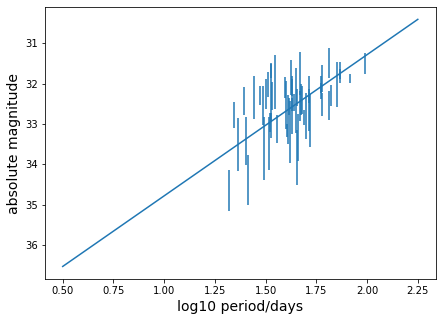

In [9]:
guess = {'a': 33, 'b':-3.5,'sigma':0.2}

guessvec = [guess[p] for p in param_names] # it will be useful to have `guess` as a vector also

plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data[g]['logP'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
xx = np.linspace(0.5, 2.25, 100)
plt.plot(xx, meanfunc(xx, data[g]['pivot'], guess['a'], guess['b']))
plt.gca().invert_yaxis();

We'll provide the familiar skeleton of function prototypes below, with a couple of small changes. One is that we added an optional argument, `Mtrue`, to the log-prior - this allows the same prior function to be used in all parts of this exercise, even when the true magnitudes are not being explicitly sampled (the function calls in later sections would simply not pass anything for `Mtrue`). The log-posterior function is also generic, in the sense that it takes as an argument the log-likelihood function it should use. Another difference is that we provide a function called `logpost_vecarg_A` ("A" referring to this part of the notebook) that takes a vector of parameters as input, ordered $a$, $b$, $\sigma$, $M_1$, $M_2$, ..., instead of a dictionary. This is for compatibility with the `emcee` sampler which is used below. (If you would like to use a different but still generic method instead, like HMC, go for it.)

In [11]:
g

1309

In [10]:
# prior, likelihood, posterior functions for a SINGLE galaxy

# generic prior for use in all parts of the notebook
def log_prior(a, b, sigma, Mtrue=None):
    '''
    `a`, `b`, and `sigma` are scalars; `Mtrue` is an array (or None)
    '''
    alogp=st.uniform.logpdf(a,loc=23,scale=20)
    blogp=st.uniform.logpdf(b,loc=-9,scale=11)
    slogp=st.uniform.logpdf(sigma,loc=0,scale=3)
    return alogp+blogp+slogp
# likelihood specifically for part A
def log_likelihood_A(gal, a, b, sigma, Mtrue):
    '''
    `gal` is an entry in the `data` dictionary; `a`, `b`, and `sigma` are scalars; `Mtrue` is an array
    '''
    return np.sum( st.norm.logpdf(Mtrue, 
                           loc=meanfunc(gal['logP'], gal['pivot'], a, b), 
                           scale=sigma) )
    
# generic posterior, again for all parts of the problem
def log_posterior(gal, loglike, **params):
    lnp = log_prior(**params)
    if lnp != -np.inf:
        lnp += loglike(gal, **params)
    return lnp

# posterior for part A, taking a parameter array argument for compatibility with emcee
def logpost_vecarg_A(pvec):
    params = {name:pvec[i] for i,name in enumerate(param_names)}
    params['Mtrue'] = pvec[len(param_names):] # everything after the named parameters is an M_{ij}
    return log_posterior(data[g], log_likelihood_A, **params)

Here's a quick sanity check, which you can refine if needed (it plugs in the measured magnitudes as a guess for the true ones):

In [11]:
data[g]['M']

array([34.64261521, 32.77361521, 33.50671521, 32.43181521, 33.41851521,
       34.38971521, 32.33981521, 32.28951521, 32.53931521, 33.59931521,
       32.25551521, 32.02361521, 33.47831521, 32.96361521, 33.03621521,
       32.22081521, 31.68981521, 32.31441521, 31.95571521, 33.11571521,
       32.09061521, 32.52681521, 33.16391521, 32.89061521, 32.57451521,
       33.20131521, 31.84931521, 32.06031521, 32.51701521, 32.56701521,
       32.45981521, 32.42231521, 32.34031521, 33.83161521, 33.33571521,
       32.54551521, 31.75341521, 32.38821521, 32.40191521, 32.83801521,
       32.79821521, 32.30391521, 32.49391521, 32.91731521, 32.19161521,
       32.02651521, 32.52181521, 31.86831521, 32.53341521, 31.47861521,
       32.29931521, 32.02571521, 31.81881521, 31.67291521, 31.87651521,
       31.50191521])

In [12]:
guess_A = np.concatenate((guessvec, data[g]['M']))
logpost_vecarg_A(guess_A)

-191.83512898641663

The cell below will set up and run `emcee` using the functions defined above. We've made some generic choices, such as using twice as many "walkers" as free parameters, and starting them distributed according to a Gaussian around `guess_A` with a width of 1%.

#### IMPORTANT

You do **not** need to run this version long enough to get what we would normally consider acceptable results, in terms of convergence and number of independent samples. Just convince yourself that it's functioning, and get a sense of how it performs (i.e., it it close to convergence already? how correlated are the samples?). The 1000 steps below should be fine, unless your starting guess was particularly strange. **Please do not turn in a notebook where the sampling cell below takes longer than $\sim30$ seconds to evaluate.**

In [13]:
%%time

nsteps = 1000 # or whatever

npars = len(guess_A)
nwalkers = 2*npars
sampler = emcee.EnsembleSampler(nwalkers, npars, logpost_vecarg_A)
start = np.array([np.array(guess_A)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
sampler.run_mcmc(start, nsteps)
print('Yay!')

Yay!
CPU times: user 58.6 s, sys: 70.9 ms, total: 58.7 s
Wall time: 58.7 s


Let's look at the usual trace plots, including only one of the magnitudes since there are so many.

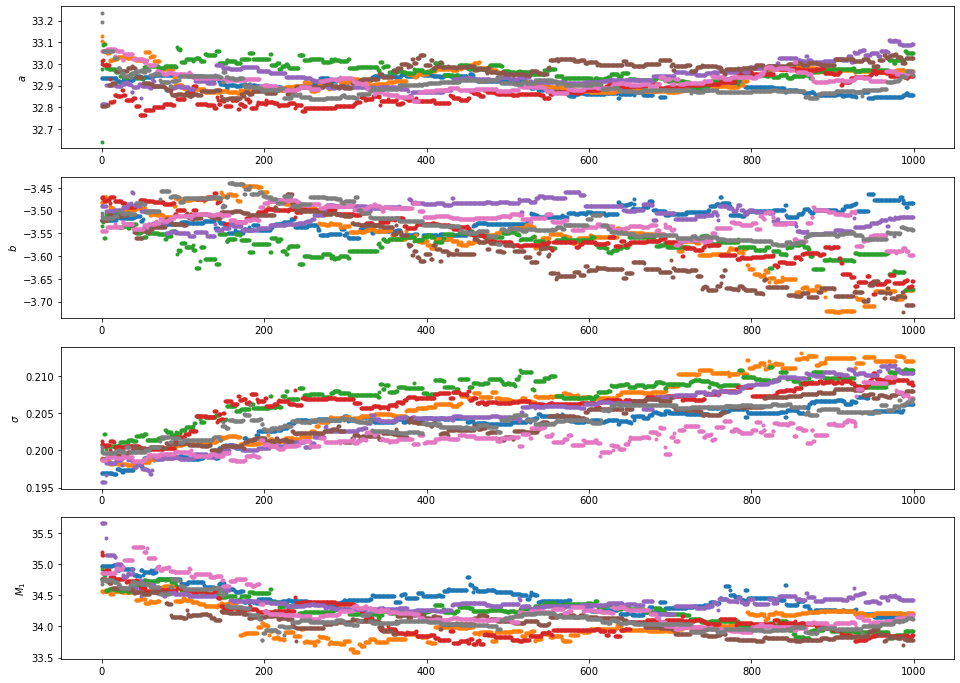

In [14]:
npars = len(guess)+1
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(sampler.chain[:min(8,nwalkers),:,:npars], ax, labels=param_labels+[r'$M_1$']);
npars = len(guess_A)

Chances are this is not very impressive. But we carry on, to have it as a point of comparison. The cell below will print out the usual quantitiative diagnostics for the subset of parameters shown above.

In [15]:
burn = 300
maxlag = 500

tmp_samples = [sampler.chain[i,burn:,:4] for i in range(nwalkers)]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
print('NB: Since walkers are not independent, these will be optimistic!')
print("Plus, there's a good chance that the results in this section are garbage...")

R = [1.68570832 1.47476545 1.36350038 1.60210927]
neff = [132.85750348 163.95873232 179.63866702 140.30628011]
NB: Since walkers are not independent, these will be optimistic!
Plus, there's a good chance that the results in this section are garbage...


Finally, we'll look at a triangle plot.

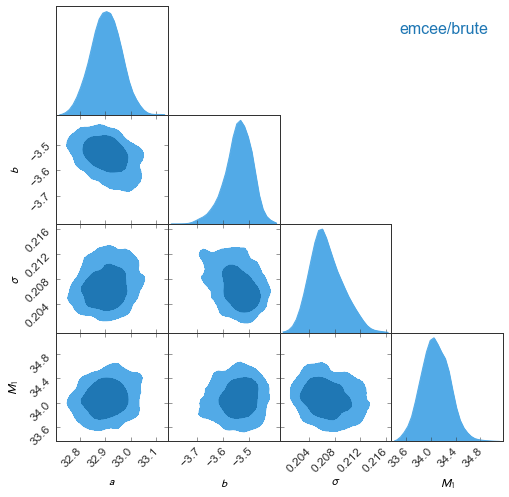

In [16]:
samples_A = sampler.chain[:,burn:,:].reshape(nwalkers*(nsteps-burn), npars)

plotGTC([samples_A[:,:4]], paramNames=param_labels+[r'$M_1$'], chainLabels=['emcee/brute'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

We should also probably look at how well the fitted model matches the data, qualitatively. This compares the posterior mean to your guess (where the chain started).

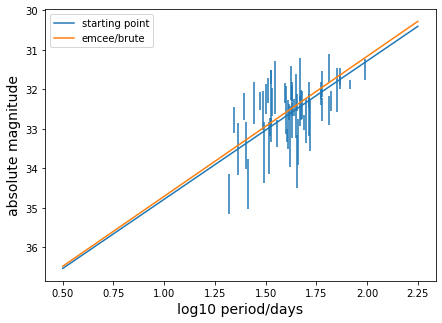

In [17]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data[g]['logP'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
xx = np.linspace(0.5, 2.25, 100)
plt.plot(xx, meanfunc(xx, data[g]['pivot'], guess['a'], guess['b']), label='starting point')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_A[:,0].mean(), samples_A[:,1].mean()), label='emcee/brute')
plt.gca().invert_yaxis();
plt.legend();

Comment on what you've seen in this section. Do you think the brute-force approach has converged (and why/not)?

YES, as it should

### 4b. Sampling with analytic marginalization

Next, implement sampling of $a$, $b$, $\sigma$ using your analytic marginalization over the true magnitudes. Again, the machinery to do the sampling is below; you only need to provide the log-posterior function.

$\mathcal{L} \propto \mathrm{Normal}(\beta | \mu_\beta, \Sigma_\beta)$,with

$\Sigma_\beta = (X^\mathrm{T}\Sigma^{-1}X)^{-1}$; $\mu_\beta = \Sigma_\beta X^\mathrm{T}\Sigma^{-1} y$.

In [20]:
print(X.shape,Sig.shape,y.shape,X.T.shape)

(56, 2) (56, 56) (56,) (2, 56)


In [65]:
y=data[g]['M']
x=data[g]['logP']
x0=data[g]['pivot']
X,Sig=[],[]
for i in range(56):
    X.append([1,x[i]-x0])
X=np.array(X)
for i in range(56):
    row=[0 for _ in range(56)]
    row[i]=data[g]['Merr'][i]
    Sig.append(row)
Sig=np.array(Sig)
Sig_inv=np.linalg.inv(Sig)
Sigbeta=np.linalg.inv(np.matmul(np.matmul(X.T,Sig_inv),X))
Mubeta=np.matmul(np.matmul(np.matmul(Sigbeta,X.T),Sig_inv),y)

def log_likelihood_B(gal, a, b, sigma):
    return st.multivariate_normal.logpdf([a,b], 
                           mean=Mubeta,
                           cov=Sigbeta)+st.norm.logpdf(sigma,0.35,0.08)
def logpost_vecarg_B(pvec):
    params = {name:pvec[i] for i,name in enumerate(param_names)}
    return log_posterior(data[g], log_likelihood_B, **params)

Check for NaNs:

In [66]:
guessvec

[33, -3.5, 0.2]

In [67]:
logpost_vecarg_B(guessvec)

-8.566131383228642

Again, we run `emcee` below. Anticipating an improvment in efficiency, we've increased the default number of steps below. Unlike the last time, you should run long enough to have useful samples in the end.

In [68]:
%%time

nsteps = 5000

npars = len(param_names)
nwalkers = 2*npars
sampler = emcee.EnsembleSampler(nwalkers, npars, logpost_vecarg_B)
start = np.array([np.array(guessvec)*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
sampler.run_mcmc(start, nsteps)
print('Yay!')

Yay!
CPU times: user 20.8 s, sys: 16.7 ms, total: 20.9 s
Wall time: 20.9 s


Again, trace plots. Note that we no longer get a trace of the magnitude parameters. If we really wanted a posterior for them, we would now need to draw samples from $p(M_{ij}|a_i,b_i,\sigma_i,\mathrm{data})$.

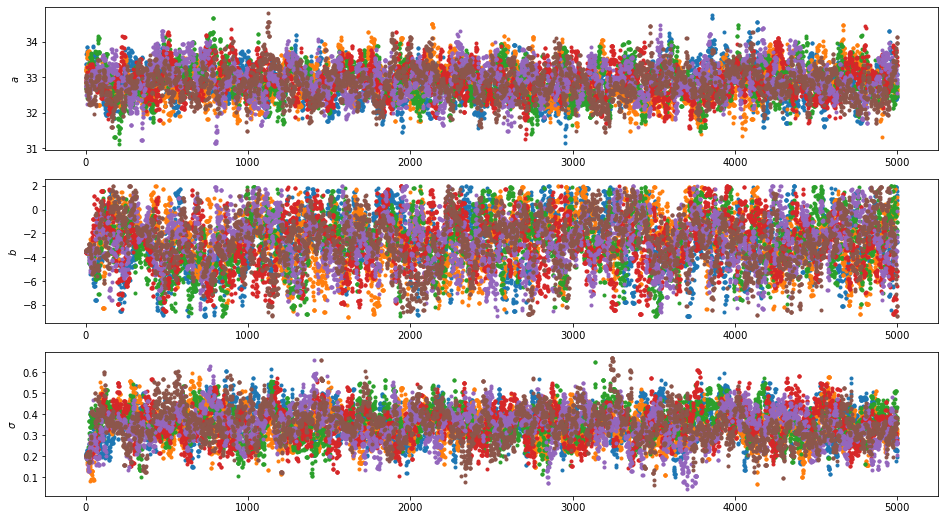

In [69]:
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(sampler.chain[:min(8,nwalkers),:,:], ax, labels=param_labels);

Again, $R$ and $n_\mathrm{eff}$.

In [70]:
burn = 200
maxlag = 500

tmp_samples = [sampler.chain[i,burn:,:] for i in range(nwalkers)]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
print('NB: Since walkers are not independent, these will be optimistic!')

R = [1.0024596  1.00133815 1.00449525]
neff = [526.32866835 446.77871631 533.43354635]
NB: Since walkers are not independent, these will be optimistic!


Now, let's compare the posterior from this analysis to the one we got before:

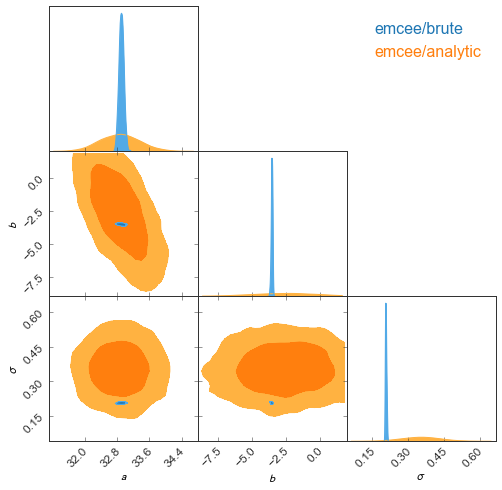

In [71]:
samples_B = sampler.chain[:,burn:,:].reshape(nwalkers*(nsteps-burn), npars)

plotGTC([samples_A[:,:3], samples_B], paramNames=param_labels, chainLabels=['emcee/brute', 'emcee/analytic'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

**Checkpoint:** Your posterior is compared with our solution by the cell below.

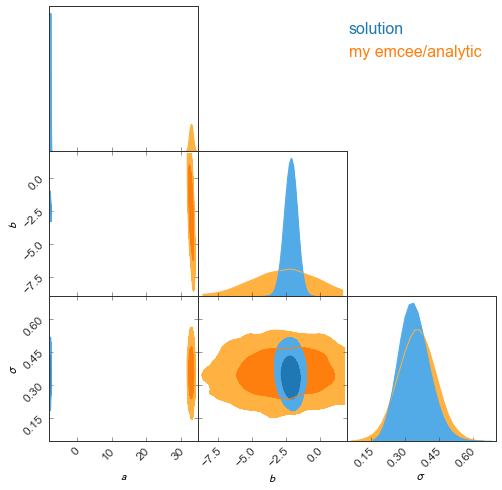

In [72]:
sol = np.loadtxt('ceph1.dat.gz')
plotGTC([sol, samples_B], paramNames=param_labels, chainLabels=['solution', 'my emcee/analytic'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Moving on, look at how the two fits you've done compare visually:

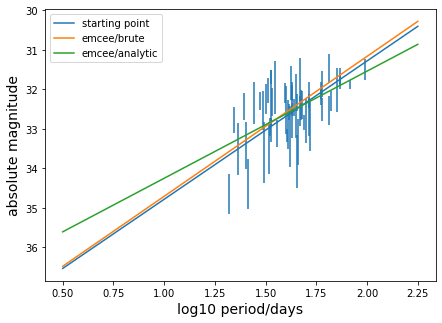

In [73]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data[g]['logP'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
xx = np.linspace(0.5, 2.25, 100)
plt.plot(xx, meanfunc(xx, data[g]['pivot'], guess['a'], guess['b']), label='starting point')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_A[:,0].mean(), samples_A[:,1].mean()), label='emcee/brute')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_B[:,0].mean(), samples_B[:,1].mean()), label='emcee/analytic')
plt.gca().invert_yaxis();
plt.legend();

Comment on things like the efficiency, accuracy, and/or utility of the approaches in these two sections.

### 4c. Conjugate Gibbs sampling

Finally, we'll step through using a specialized Gibbs sampler to solve this problem. We'll use the `LRGS` package, not because it's the best option (it isn't), but because it's written in pure Python. The industry-standard (and far less specialized) alternative goes by the name JAGS, and requires a separate installation (though one can add a Python interface on top of that).

As we alluded to earlier, `LRGS` will actually sample all of the magnitude parameters, basically performing a more intelligent but still brute-force sampling of the posterior. I've forgotten how to extract the posterior for the magnitudes from the sampler (they aren't stored by default), but it would be interesting to include one of them in the trace/triangle plots, as we did for the emcee/brute solution.

Let me stress that LRGS is in no fashion optimized for speed; JAGS is presumably faster, not to mention applicable to more than just fitting lines. Even so, LRGS seems to be comparable in speed with our analytically supercharged `emcee` in this case, when one considers that the samples it returns are less correlated.

There are no `TBC`s in the code here, we just think it's neat to compare another method.

In [74]:
import lrgs

LRGS is a "general" linear model fitter, meaning that $x$ and $y$ can be multidimensional. So the input data are formatted as matrices with one row for each data point. In this case, they're column vectors ($n\times1$ matrices).

Measurement uncertainties are given as a list of covariance matrices. The code handles errors on both $x$ and $y$, so these are $2\times2$ for us. Since our $x$'s are given precisely, we just put in a dummy value here and use a different option to fix the values of $x$ below.

In [75]:
x = np.asmatrix(data[g]['logP'] - data[g]['pivot']).T
y = np.asmatrix(data[g]['M']).T
M = [np.matrix([[1e-6, 0], [0, err**2]]) for err in data[g]['merr']]

Conjugate Gibbs sampling can be parallelized in the simplest possible way - you just run multiple chains from different starting points or even just with different random seeds in parallel. (`emcee` is parallelized internally, since walkers need to talk to each other.) Therefore...

In [76]:
import multiprocessing

This function sets things up and does the actual sampling, returning a `numpy` array in the usual format. The default priors are equivalent to the ones we chose above, helpfully.

In [77]:
nsteps = 2000 # some arbitrary number of steps to run

def do_gibbs(i):
    # every parallel process will have the same random seed if we don't reset them to different values here
    if i > 0:
        np.random.seed(i*42)
    # lrgs.Parameters set up a sampler that assumes the x's are known precisely.
    # Other classes would correspond to different possible priors on x.
    par = lrgs.Parameters(x, y, M)
    chain = lrgs.Chain(par, nsteps)
    chain.run(fix='x') # fix='x' isn't necessary here, but it shows how one would fix other parameters if we wanted to
    # Extracts the chain as a dictionary. Note that we have the option of hanging onto the samples of the magnitude
    #  parameters in addition to the intercept, slope and scatter, though this is not the default.
    dchain = chain.to_dict(["B", "Sigma"])
    # since $sigma^2$ is sampled rather than $\sigma$, take the square root here
    return np.array([dchain['B_0_0'], dchain['B_1_0'], np.sqrt(dchain['Sigma_0_0'])]).T

Go!

In [78]:
%%time
#with multiprocessing.Pool() as pool:
#    gibbs_samples = pool.map(do_gibbs, range(2)) # 2 parallel processes - change if you want

# latest Python doesn't appreciate my use of multiprocessing, so I guess we'll just wait twice as long

gibbs_samples = [do_gibbs(i) for i in range(2)]

CPU times: user 33.1 s, sys: 11.4 s, total: 44.5 s
Wall time: 22.4 s


Show!

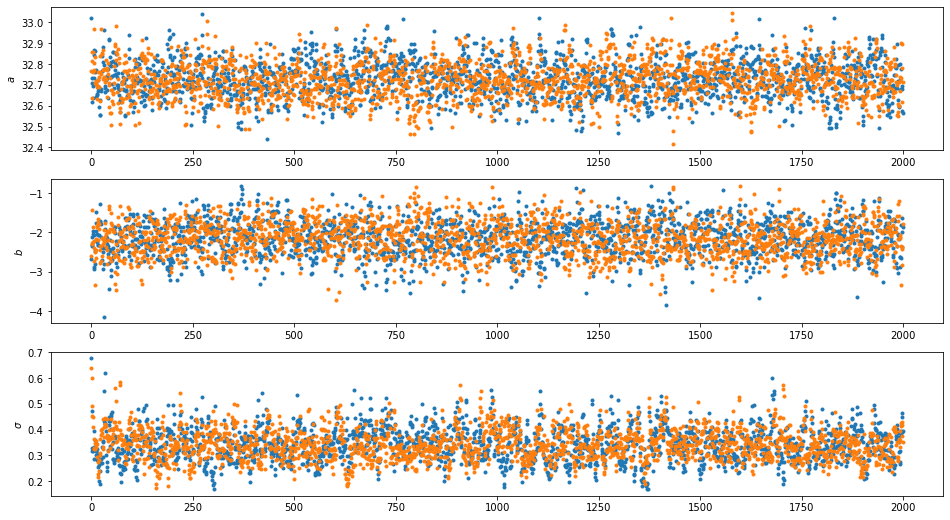

In [79]:
plt.rcParams['figure.figsize'] = (16.0, 3.0*npars)
fig, ax = plt.subplots(npars, 1);
cr.plot_traces(gibbs_samples, ax, labels=param_labels);

In [80]:
burn = 50
maxlag = 1000

tmp_samples = [x[burn:,:] for x in gibbs_samples]
print('R =', cr.GelmanRubinR(tmp_samples))
print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))

R = [0.99998622 0.9998002  0.99974859]
neff = [1087.58700496 1309.04061786  699.77734056]


Here are the posteriors:

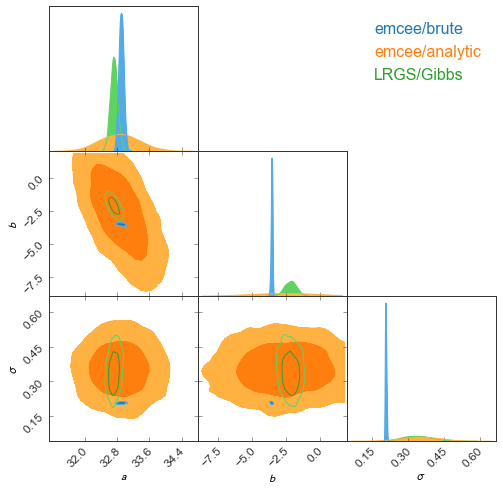

In [81]:
samples_C = np.concatenate(tmp_samples, axis=0)

plotGTC([samples_A[:,:3], samples_B, samples_C], paramNames=param_labels,
        chainLabels=['emcee/brute', 'emcee/analytic', 'LRGS/Gibbs'],
        figureSize=8, customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Again, look at the fit compared with the other methods. (Note that `lrgs` comes up with its own intial guess, so the "starting point" line only applies to our `emcee` solutions.)

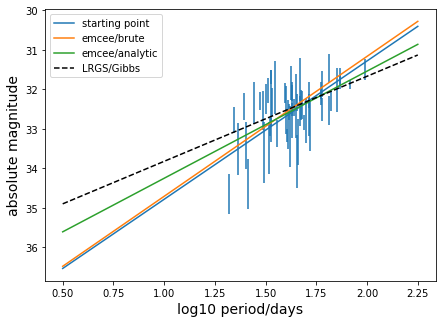

In [82]:
plt.rcParams['figure.figsize'] = (7.0, 5.0)
plt.errorbar(data[g]['logP'], data[g]['M'], yerr=data[g]['merr'], fmt='none');
plt.xlabel('log10 period/days', fontsize=14);
plt.ylabel('absolute magnitude', fontsize=14);
xx = np.linspace(0.5, 2.25, 100)
plt.plot(xx, meanfunc(xx, data[g]['pivot'], guess['a'], guess['b']), label='starting point')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_A[:,0].mean(), samples_A[:,1].mean()), label='emcee/brute')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_B[:,0].mean(), samples_B[:,1].mean()), label='emcee/analytic')
plt.plot(xx, meanfunc(xx, data[g]['pivot'], samples_C[:,0].mean(), samples_C[:,1].mean()), '--', label='LRGS/Gibbs', color='k')
plt.gca().invert_yaxis();
plt.legend();

## Parting thoughts

Be honest - were you expecting one of the more challenging problems in the final part of the course to be... fitting a line? The least squares method, whose solution is 100% algebraic, has been around for a couple of centuries. Yet by introducing one feature of the model that breaks the assumptions needed for least squares - intrinsic scatter, something that is completely generic in real situations - we find ourselves needing to find creative solutions to computationally complex problems. This is not an excuse for giving up and using least squares! Hopefully this tutorial has, however, convinced you that it's worth thinking about exactly how to implement the Bayesian solution - and that problems that seem computationally unfeasible at first can turn out to be quite tractable with the application of a little brain-elbow grease.